# Planning TWEAC Setup for Figure-of-Merit Run<a class="tocSkip">

## Imports

In [1]:
%pylab inline
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
import os
import sys
sys.path.append("/home/s7470087/2019-10_TWEAC-for-Summit/picsrc/lib/python/")
from scipy import constants as sc
from picongpu.utils import MemoryCalculator

Populating the interactive namespace from numpy and matplotlib


## Override Matplotlib Defaults

In [2]:
# OVERWRITE DEFAULT PLOTTING PARAMETERS
params = {
    'font.size' : 20,
    'lines.linewidth' : 3,
    'legend.fontsize' : 20,
    'legend.frameon' : False,
    'legend.numpoints': 1,
    'xtick.labelsize' : 20,
    'ytick.labelsize' : 20,
    'figure.figsize': [12,8],
    'axes.labelsize' : 20
}
mpl.rcParams.update(params)

# Simulation Parameters

## Function definitions

In [3]:
def critical_density_si(lambda_laser):
    """ Critical electron number density at which an 
        incident light wave is reflected from a surface.
        Units [1/m^3]
    """
    return (sc.epsilon_0*sc.m_e/sc.e**2)*(2.*pi*sc.c/lambda_laser)**2

def critical_density(lambda_laser):
    """ Critical electron number density in [1/cm^3]
    """
    return critical_density_si(lambda_laser)*1.e-6

def plasma_angular_frequency(n_e):
    """ 
    """
    return sqrt( n_e * sc.e**2 / ( sc.epsilon_0 * sc.m_e ) )

def plasma_oscillation_length(n_e):
    """ Assuming the driver propagates at the speed of light
    """
    omega_p = plasma_angular_frequency(n_e)
    return 2.*sc.pi*sc.c/omega_p

def debye_length(n_e, T , Z):
    """ electron temperature [T] = eV
        electron density [n_e] = cm^-3
    """
    return 743.*sqrt(T/(1.+Z)/n_e)  # sqrt(epsilon_0*k_B*T/n_e/e_charge**2/(1.+Z))

## Laser parameters

```c++
twtsFieldE1(
    /* focus_y [m], the distance to the laser focus in y-direction */
    30.0e-6,
    /* wavelength [m] */
    0.8e-6,
    /* pulselength [s], sigma of std. gauss for intensity (E^2) */
    10.0e-15 / 2.3548200450309493820231386529194,
    /* w_x [m], cylindrically focused spot size */
    1.2e-6,
    /* w_y [m] */
    0.1,
    /* interaction angle between TWTS laser propagation vector and the y-axis [rad] */
    3.5 * (PI/180.),
    /* propagation speed of overlap [speed of light]. */
    1.0,
    /* manual time delay [s] if auto_tdelay is false */
    50.0e-6 / SI::SPEED_OF_LIGHT_SI,
    /* Should PIConGPU automatically choose a suitable time delay? [true/false] */
    false,
    /* Polarization of TWTS laser field */
    templates::twts::EField::LINEAR_X
),
```

```c++
/** Specify your background field E(r,t) here
*
* \param cellIdx The total cell id counted from the start at t=0
* \param currentStep The current time step */
HDINLINE float3_X
operator()( const DataSpace<simDim>& cellIdx,
        const uint32_t currentStep ) const
{
    
    //
    // Calculation of amplitude
    //

    /* Note: twtsFieldE(...) is normalized, such that peak amplitude equals unity. */
    return    float3_X::create(0.7057829460593135) * amplitude * twtsFieldE1( cellIdx, currentStep )
            - float3_X::create(0.7057829460593135) * amplitude * twtsFieldE2( cellIdx, currentStep )
            + float3_X::create(0.7084281424758874) * amplitude * twtsFieldE3( cellIdx, currentStep )
            + float3_X::create(0.7084281424758874) * amplitude * twtsFieldE4( cellIdx, currentStep );
}
```

In [4]:
# LASER

## Change w_0x to Rayleighlength >~ Plasma oscillation length
## Change pulse duration to tau_FWHM,I = 30fs -> sigma_t,E = tau_FWHM,I / sqrt(2. * log(2.)) / sqrt(2)
## sigma_t,E = tau_FWHM,I / 1.6651 = 18.0168
## lower a0 to just enter the bubble regime

λ_0 = 800e-9 # laser wavelength
print("Laser period = %.1es"%(λ_0/sc.c))

ϕ = 3.5 * sc.pi / 180.
print("ϕ = %.1fdeg"%(ϕ*180./pi))

# beam waist in focus
w_0x = 5.5e-6
print("w_0 = {:.2f} µm".format(w_0x * 1e6))

# Rayleigh length
z_r = 1 * np.pi * w_0x**2 / λ_0
print("z_r = {:.2f} µm".format(z_r * 1e6))

Laser period = 2.7e-15s
ϕ = 3.5deg
w_0 = 5.50 µm
z_r = 118.79 µm


In [5]:
n_c = critical_density(λ_0)*1.e6
print("critical e density for λ_Laser = %.1e/m^3"%(n_c))
print("plasma frequency at critical density = %.1erad/s"%(plasma_angular_frequency(n_c)))
print("plasma period at critical density = %.1es (= laser period)"%(2.*sc.pi/plasma_angular_frequency(n_c)))

critical e density for λ_Laser = 1.7e+27/m^3
plasma frequency at critical density = 2.4e+15rad/s
plasma period at critical density = 2.7e-15s (= laser period)


## Plasma parameters

In [6]:
BASE_DENSITY_SI = 0.8e+23 #0.25e+25 #0.8e+23 # unit: ELEMENTS/m^3
PLATEAU_DENSITY_SI = 2. * BASE_DENSITY_SI

In [7]:
PLASMA_FREQUENCY_SI = plasma_angular_frequency(PLATEAU_DENSITY_SI)
print("plasma frequency at plateau density = %.1erad/s"%(PLASMA_FREQUENCY_SI))
print("plasma period at plateau density = %.1es"%(2.*sc.pi/PLASMA_FREQUENCY_SI))
λ_plasma = plasma_oscillation_length(PLATEAU_DENSITY_SI)
print("plasma oscillation length at plateau density = %.1fmum"%(λ_plasma*1.e6))
print("plasma skin depth = %.1fmum"%(sc.c/PLASMA_FREQUENCY_SI*1.e6))

plasma frequency at plateau density = 2.3e+13rad/s
plasma period at plateau density = 2.8e-13s
plasma oscillation length at plateau density = 83.5mum
plasma skin depth = 13.3mum


In [8]:
λ_plasma_base = plasma_oscillation_length(BASE_DENSITY_SI)
print("plasma frequency at base density = %.1erad/s"%(plasma_angular_frequency(BASE_DENSITY_SI)))
print("plasma oscillation length at base density = %.1fmum"%(λ_plasma_base*1.e6))

plasma frequency at base density = 1.6e+13rad/s
plasma oscillation length at base density = 118.0mum


In [9]:
print("Rayleighlength / plasma oscillation length =", z_r / λ_plasma)
print("Rayleighlength / base plasma oscillation length =", z_r / λ_plasma_base)

Rayleighlength / plasma oscillation length = 1.4231026107584621
Rayleighlength / base plasma oscillation length = 1.0062855063915883


## Mesh parameters

In [162]:
dx_old = 0.6645e-7
dy_old = 0.383649e-7
dz_old = dy_old

n_e_old = 0.25e25 # unit: ELEMENTS/m^3
λ_plasma_old = plasma_oscillation_length(n_e_old)

print("λ_plasma = %.5fμm"%(λ_plasma_old*1.e6))

Lx_old = dx_old*1120
Ly_old = dy_old*2304
Lz_old = dz_old*6144
print("λ_plasma / dx =", λ_plasma / dx_old )
print("λ_Laser / dy =", λ_0 / dy_old )
print("λ_plasma / dz =", λ_plasma / dz_old )
print("x Ausdehnung", Lx_old*1.e6, "μm =", Lx_old / λ_plasma_old, "λ_plasma =", Lx_old / w_0x, "w_0x")
print("y Ausdehnung", Ly_old*1.e6, "μm =", Ly_old / λ_plasma_old, "λ_plasma")
print("z Ausdehnung", Lz_old*1.e6, "μm =", Lz_old / λ_plasma_old, "λ_plasma =", Lz_old / z_r, "z_r")

λ_plasma = 21.11733μm
λ_plasma / dx = 1256.1863328444522
λ_Laser / dy = 20.85239372447211
λ_plasma / dz = 2175.7799920634184
x Ausdehnung 74.424 μm = 3.524308940864691 λ_plasma = 13.531636363636364 w_0x
y Ausdehnung 88.39272960000001 μm = 4.1857907024174335 λ_plasma
z Ausdehnung 235.71394560000002 μm = 11.162108539779823 λ_plasma = 1.9842665572461022 z_r


In [10]:
# box length in y direction, from experience with Piz Daint simulation
L_y = 8. * λ_plasma_base
print("box length in y: {:.2f} µm".format(L_y * 1e6))

# box length in z direction, from experience with Piz Daint simulation (the laser pulse is not bounded in z-direction)
L_z = 15. * z_r
print("box length in z: %.2f µm = %.2f λ_plasma"%(L_z * 1e6, L_z / λ_plasma))

# box length in x direction,
# from the typical criterion for 99% of beam power: pi * w for transversal size
# should fit into the simulation in order to properly model the propagation of the focusing field.
w_init = w_0x * np.sqrt(1 + (.5*L_z / z_r)**2)
print("w_init = {:.2f} µm".format(w_init * 1e6))
print(r"π * w_init = {:.2f} µm".format(np.pi * w_init * 1e6))

# take even more than maybe required from defocusing, also fit two plasma wavelength in the x-direction
L_x = 240.e-6 # m
print("box length in x: {:.2f} µm".format(L_x * 1e6))

box length in y: 944.40 µm
box length in z: 1781.87 µm = 21.35 λ_plasma
w_init = 41.62 µm
π * w_init = 130.74 µm
box length in x: 240.00 µm


### Strict constraints

#### Transverse and longitudinal sampling

In [11]:
## If the projected laser period in the transverse direction is longer than the plasma oscillation length,
## I choose a cell size with equal length in x and z direction.
print("Transverse laser oscillation length / plasma oscillation length =", λ_0 * sin(ϕ) / λ_plasma)

Transverse laser oscillation length / plasma oscillation length = 0.000585081298352031


<span style="color:red;font-size:xlarge;font-face:bold">Vergleiche für Z-Auflösung besser den Fehler der numerischen Group velocity während der propagation durch das Gas (L_cyc/sin(phi)) relativ zur Plasmawellenlaenge und halte es im Promillebereich!</span>

Die numerische Gruppengeschwindigkeit ist gegeben aus der Ableitung der numerischen Phasengeschwindigkeit.
Die numerische Phasengeschwindigkeit wird ermittelt aus der Dispersionsrelation (4.12) im Taflove
$$
  \left [\frac{1}{c\Delta t}\sin\left( \frac{\omega \Delta t}{2} \right) \right]^2 =
      \left [\frac{1}{\Delta x}\sin\left( \frac{k_x \Delta x}{2} \right) \right]^2
      + \left [\frac{1}{\Delta y}\sin\left( \frac{k_y \Delta y}{2} \right) \right]^2
      + \left [\frac{1}{\Delta z}\sin\left( \frac{k_z \Delta z}{2} \right) \right]^2
$$
in dem diese nach $\omega$ aufgelöst wird und 
$$
  v_\mathrm{phase} = \frac{\omega}{k}\,.
$$
Die Gruppengeschwindigkeit ist definiert als
$$
  v_\mathrm{group} = \frac{\partial \omega}{\partial k}\,.
$$
Es gilt
$$
  \frac{\partial}{\partial k} \left[ \frac{1}{c\Delta t} \sin\left( \frac{\omega \Delta t}{2} \right) \right]^2
  = \frac{1}{c^2\Delta t^2} 2 \sin\left( \frac{\omega \Delta t}{2} \right)
    \cos\left( \frac{\omega \Delta t}{2} \right)
    \frac{\Delta t}{2} \frac{\partial \omega}{\partial k}
$$
Deswegen
$$
  \frac{\partial \omega}{\partial k} =
  \frac{c^2\Delta t^2}{ 2 \sin\left( \frac{\omega \Delta t}{2} \right)
    \cos\left( \frac{\omega \Delta t}{2} \right)
    \frac{\Delta t}{2}}
  \frac{\partial}{\partial k} \left[ \frac{1}{c\Delta t} \sin\left( \frac{\omega \Delta t}{2} \right) \right]^2
$$

$$
  \frac{\partial \omega}{\partial k} =
  \frac{c^2\Delta t}{ \sin\left( \frac{\omega \Delta t}{2} \right)
    \cos\left( \frac{\omega \Delta t}{2} \right)
    }
  \frac{\partial}{\partial k} \left[ \frac{1}{c\Delta t} \sin\left( \frac{\omega \Delta t}{2} \right) \right]^2
$$

Dort die rechte Seite der Dispersionsrelation einsetzen und für die karthesischen $k_i$ diese Darstellung für $k$ einsetzen

$$
  (k_x, k_y, k_z) = k ( \sin\vartheta \cos\varphi, \sin\vartheta \sin\varphi, \cos\vartheta)
$$

und ableiten.

Für unsere Propagation in der $y$-$z$-Ebene entlang einer Richtung die einen Winkel von $3.5^\circ$ mit der $y$-Achse einschliesst ist $\varphi = 90^\circ$ und $\vartheta = 86.5^\circ$.

Nutze ausserdem die Relationen 
$$
  S = c\Delta t \sqrt{\frac{1}{\Delta x^2}
                      + \frac{1}{\Delta y^2}
                      + \frac{1}{\Delta z^2}}
    =: \frac{c \Delta t}{\Delta}
  \qquad \text{Courant stabilty factor (Taflove (4.98))}\,,
$$
$$
  \omega \Delta t = \frac{2\pi c \Delta t}{\lambda} 
  = \frac{2 \pi S}{\lambda \sqrt{\frac{1}{\Delta x^2} + \frac{1}{\Delta y^2} + \frac{1}{\Delta z^2}} }
  = 2 \pi S \frac{\Delta}{\lambda}\,.
$$

$$
\sin\left( \frac{\omega \Delta t}{2} \right) =
      c\Delta t
      \sqrt{
      \left [\frac{1}{\Delta x}\sin\left( \frac{k_x \Delta x}{2} \right) \right]^2
      + \left [\frac{1}{\Delta y}\sin\left( \frac{k_y \Delta y}{2} \right) \right]^2
      + \left [\frac{1}{\Delta z}\sin\left( \frac{k_z \Delta z}{2} \right) \right]^2
      }
$$
$$
\frac{\omega \Delta t}{2} =
      \mathrm{Arcsin}\left(
      c\Delta t
      \sqrt{
      \left [\frac{1}{\Delta x}\sin\left( \frac{k_x \Delta x}{2} \right) \right]^2
      + \left [\frac{1}{\Delta y}\sin\left( \frac{k_y \Delta y}{2} \right) \right]^2
      + \left [\frac{1}{\Delta z}\sin\left( \frac{k_z \Delta z}{2} \right) \right]^2
      }
      \right)
$$
$$
\omega =
      \frac{2}{\Delta t}
      \mathrm{Arcsin}\left(
      c\Delta t
      \sqrt{
      \left [\frac{1}{\Delta x}\sin\left( \frac{k_x \Delta x}{2} \right) \right]^2
      + \left [\frac{1}{\Delta y}\sin\left( \frac{k_y \Delta y}{2} \right) \right]^2
      + \left [\frac{1}{\Delta z}\sin\left( \frac{k_z \Delta z}{2} \right) \right]^2
      }
      \right)
$$

Das Ding kann man auch ableiten. Dann unseren Dall mit $k_x = 0$ und $k=2\pi/\lambda_\mathrm{Laser}$ einsetzen und eine interessante Größe in Abhängigkeit von $\Delta z$ auftragen und dann ein passendes $\Delta z$ bestimmen.

Dann noch mit der CFL Bedingung das $\Delta x$ ausrechnen und schauen ob es die Plasmawellenlänge gut auflöst. Oder $\Delta x$ auch noch vorgeben und mit CFL den Zeitschritt ausrechnen.

$$
  \frac{\partial \omega}{\partial k} =
  \frac{c S \Delta}{ \sin\left( \pi S \frac{\Delta}{\lambda} \right)
    \cos\left( \pi S \frac{\Delta}{\lambda} \right)
    }
  \left[ \frac{1}{\Delta x} \sin\left( \pi \sin\vartheta \cos\varphi \frac{\Delta x}{\lambda} \right)
           \cos\left( \pi \sin\vartheta \cos\varphi \frac{\Delta x}{\lambda} \right)
           \sin\vartheta \cos\varphi
         + \frac{1}{\Delta y} \sin\left( \pi \sin\vartheta \sin\varphi \frac{\Delta y}{\lambda} \right)
           \cos\left( \pi \sin\vartheta \sin\varphi \frac{\Delta y}{\lambda} \right)
           \sin\vartheta \sin\varphi
         + \frac{1}{\Delta z} \sin\left( \pi \cos\vartheta \frac{\Delta z}{\lambda} \right)
           \cos\left( \pi \cos\vartheta \frac{\Delta z}{\lambda} \right)
           \cos\vartheta
  \right]
$$

In [12]:
def Delta(Dx, Dy, Dz):
    return 1./np.sqrt(1./Dx**2 + 1./Dy**2 + 1./Dz**2)


def v_g(wavel, theta, phi, Dx, Dy, Dz, S):
    Dd = Delta(Dx, Dy, Dz)
    omega_dt_2 = sc.pi * S * Dd / wavel
    
    arg_ekx = np.sin(theta) * np.cos(phi)
    arg_x = sc.pi * arg_ekx * Dx / wavel
    
    arg_eky = np.sin(theta) * np.sin(phi)
    arg_y = sc.pi * arg_eky * Dy / wavel
    
    arg_ekz = np.cos(theta)
    arg_z = sc.pi * arg_ekz * Dz / wavel
    
    return ( sc.c * S * Dd / ( np.sin(omega_dt_2) * np.cos(omega_dt_2) ) 
             * ( np.sin(arg_x) * np.cos(arg_x) * arg_ekx / Dx
                 + np.sin(arg_y) * np.cos(arg_y) * arg_eky / Dy
                 + np.sin(arg_z) * np.cos(arg_z) * arg_ekz / Dz
               )
           )


#def v_g_phys(λ, a_0, n_e):
#    ''' Aus Esarey RoMP 2009 (?)
#    '''
#    ω_p = plasma_angular_frequency(n_e)
#    ω = 2.*sc.pi*sc.c/λ
#    γ_g = ω / ω_p
#    return np.sqrt( 1. - 1./γ_g**2 ) * sc.c

In [13]:
## The cell length in the longitudinal direction is given by the laser wavelength
dy_strict = λ_0 / 40.
print("dy = {:.5e} m".format(dy_strict))
print("sanity check: longitudinal samples per laser wavelength λ_laser: %.2f"%(λ_0/dy_strict))

dy = 2.00000e-08 m
sanity check: longitudinal samples per laser wavelength λ_laser: 40.00


In [14]:
## The cell length in the transverse directions is given by Courant-Friedrich-Levy condition (eq. (4.98) in Taflove)
## and needs to be much smaller than the plasma oscillation length.
## A large aspect ratio is also not good since we will end up with a lot of particles per cell in the region
## of the accelerated bunch.
## Furthermore, in the sheeth region of the bubble we expect very high density, maybe 1-2 orders of magnitude higher
## than in the base density, and we do not want to model this region completely incorrect.
## Therefore we assume a maximum factor for the aspect ratio.
dx_strict = 8. * dy_strict #λ_plasma / 80.
print("dx = %.5em"%(dx_strict))
print("Samples per plasma oscillation length λ_p = 2πc/ω_p: %.2f"%(λ_plasma/dx_strict))

dx = 1.60000e-07m
Samples per plasma oscillation length λ_p = 2πc/ω_p: 521.71


In [15]:
## Define Courant factor S and laser strength a_0 for Dz determination
S = 0.995
print("ϕ = %.1fdeg"%(ϕ*180./pi))
theta = .5 * sc.pi - ϕ
print("theta = %.1fdeg"%(theta*180./pi))
phi = .5 * sc.pi
print("phi = %.1fdeg"%(phi*180./pi))
a_0 = 3.0

dz = np.linspace(dy_strict, 5.*dx_strict, 500)

ϕ = 3.5deg
theta = 86.5deg
phi = 90.0deg


In [16]:
print("dz[0] / dy =", dz[0] / dy_strict)
print("numerical group velocity v_g / c = %.8f"%(v_g(λ_0, theta, phi, dx_strict, dy_strict, dz[0], S)/sc.c))
print("physical group velocity error Δv_g / c = %.8f"%(v_g(λ_0, theta, phi, dx_strict, dy_strict, dz[0], S)/sc.c - 1.))

dz[0] / dy = 1.0
numerical group velocity v_g / c = 0.99793771
physical group velocity error Δv_g / c = -0.00206229


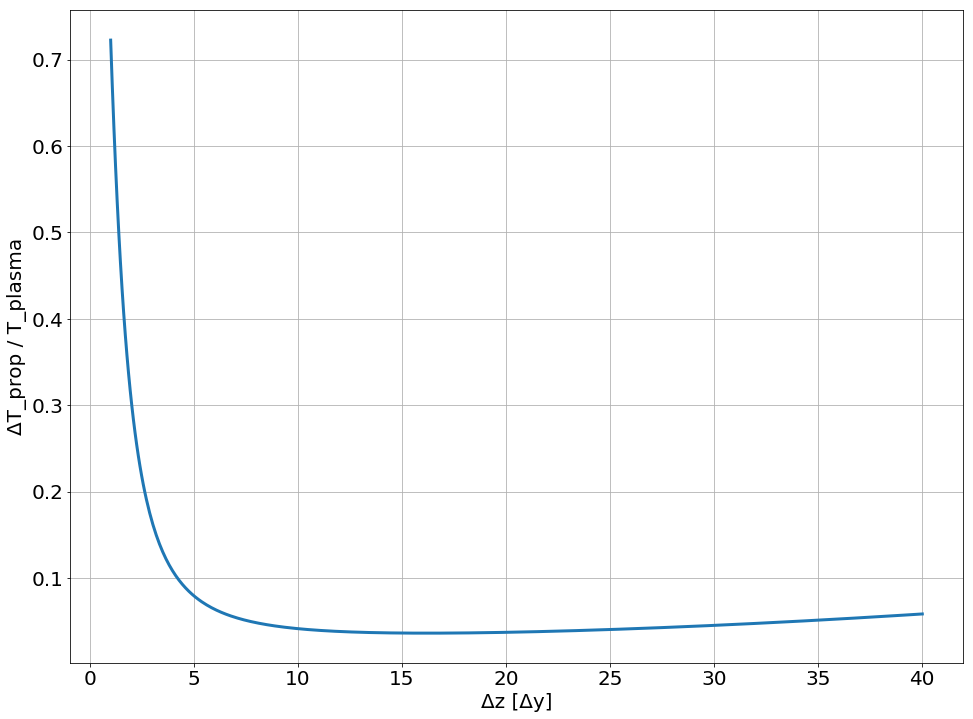

In [17]:
ΔT_prop = L_z / np.sin(ϕ) * ( 1./v_g(λ_0, theta, phi, dx_strict, dy_strict, dz, S) - 1./sc.c)
T_plasma = 2.*sc.pi/PLASMA_FREQUENCY_SI

figure(figsize=(16,12))

plot(dz/dy_strict, ΔT_prop / T_plasma)

xlabel("Δz [Δy]")
ylabel("ΔT_prop / T_plasma")

#xticks(np.arange(0., dz[-1] / dy_strict, 2))

#xlim(0,50)

grid()

show()

There is a minimum in the physical group-velocity error $\Delta v_\mathrm{g}$!

In [18]:
dz_min = np.argmin(ΔT_prop / T_plasma)
print("Minimum at %i: Dz = %i Dy"%(dz_min, dz[dz_min]/dy_strict))

Minimum at 194: Dz = 16 Dy


In [19]:
## Choose dz to have the numerical group velocity error at a minimum
dz_strict = 8.*dy_strict

#### Temporal sampling

In [20]:
## Calculate the time sampling from the CFL condition
dt_strict = S * Delta(dx_strict, dy_strict, dz_strict) / sc.c

In [21]:
print("sanity check: temporal samples per laser period λ_Laser / c Δt =", λ_0 / sc.c / dt_strict)
print("sanity check: Δy / c Δt =", dy_strict / sc.c / dt_strict)
print("sanity check CFL condition: c Δt =", sc.c * dt_strict, "<", 1./sqrt( 1./dx_strict**2 + 1./dy_strict**2 + 1./dz_strict**2 ), "!?")

sanity check: temporal samples per laser period λ_Laser / c Δt = 40.82431359113547
sanity check: Δy / c Δt = 1.0206078397783866
sanity check CFL condition: c Δt = 1.9596165363909774e-08 < 1.969463855669324e-08 !?


In [22]:
print("Summary of sampling parameters")
print("==============================")
print("dt = %.5es = %.3f T_Laser = %.1e T_Plasma"%(dt_strict, dt_strict/(λ_0 / sc.c), dt_strict/(2. * sc.pi / PLASMA_FREQUENCY_SI)))
print("dx = %.5em = %.3f λ_Laser = %.1e λ_Plasma"%(dx_strict, dx_strict/λ_0, dx_strict/λ_plasma_base))
print("dy = %.5em = %.3f λ_Laser = %.1e λ_Plasma"%(dy_strict, dy_strict/λ_0, dy_strict/λ_plasma_base))
print("dz = %.5em = %.3f λ_Laser = %.1e λ_Plasma"%(dz_strict, dz_strict/λ_0, dz_strict/λ_plasma_base))

Summary of sampling parameters
dt = 6.53658e-17s = 0.024 T_Laser = 2.3e-04 T_Plasma
dx = 1.60000e-07m = 0.200 λ_Laser = 1.4e-03 λ_Plasma
dy = 2.00000e-08m = 0.025 λ_Laser = 1.7e-04 λ_Plasma
dz = 1.60000e-07m = 0.200 λ_Laser = 1.4e-03 λ_Plasma


In [23]:
print("Typical particles per cell =", BASE_DENSITY_SI * dx_strict * dy_strict * dz_strict)

Typical particles per cell = 40.96


### Simulation window volume

In [24]:
box_cells_x_raw = np.int(L_x / dx_strict)
print("box L_x: ",box_cells_x_raw)
box_cells_y_raw = np.int(L_y / dy_strict)
print("box L_y: ",box_cells_y_raw)
box_cells_z_raw = np.int(L_z / dz_strict)
print("box L_z: ",box_cells_z_raw)

cells_norm = box_cells_x_raw
print("Ratio of box dimensions [cells] : x : y : z = %.1f : %.1f : %.1f"%(box_cells_x_raw/cells_norm, box_cells_y_raw/cells_norm, box_cells_z_raw/cells_norm))

box L_x:  1500
box L_y:  47219
box L_z:  11136
Ratio of box dimensions [cells] : x : y : z = 1.0 : 31.5 : 7.4


### Calculate the real number of cells in the box

Aim for a simulation volume per GPU that has an approximately even number of cells in all directions.

Berechne Verhältnis der Boxlängen zueinander und nimm selbes Verhältnis für Verteilung der Grafikkarten.

In [25]:
# domain decomposition
n_scale = 4.6
gpus_x_raw = 1 * n_scale
gpus_y_raw = 32 * n_scale
gpus_z_raw = 8. * n_scale

print("GPUs raw x : y : z = %.1f : %.1f : %.1f"%(gpus_x_raw, gpus_y_raw, gpus_z_raw))
print("total number of gpus raw:", gpus_x_raw * gpus_y_raw * gpus_z_raw)

GPUs raw x : y : z = 4.6 : 147.2 : 36.8
total number of gpus raw: 24918.015999999992


In [26]:
# domain decomposition
gpus_x = 5 
gpus_y = 145
gpus_z = 35

print("GPUs x : y : z = %.1f : %.1f : %.1f"%(gpus_x, gpus_y, gpus_z))
print("total number of gpus:", gpus_x * gpus_y * gpus_z)

# super cell
super_cell = np.array([8, 8, 4])

## box_raw = np.array([box_cells_x_raw, box_cells_y_raw, box_cells_z_raw])
## Scale to smaller volume for Summit
box_raw = np.array([box_cells_x_raw, box_cells_y_raw, box_cells_z_raw]) / 2**(1./3.)
gpu_raw = np.array([box_raw[0] / gpus_x / super_cell[0]
                    , box_raw[1] / gpus_y / super_cell[1]
                    , box_raw[2] / gpus_z / super_cell[2]])

print("simulation box size raw =", box_raw)
print("super cells per gpu:", gpu_raw)

GPUs x : y : z = 5.0 : 145.0 : 35.0
total number of gpus: 25375
simulation box size raw = [ 1190.55078898 37477.74513644  8838.64905736]
super cells per gpu: [29.76376972 32.30840098 63.13320755]


In [27]:
box_cells_x = 30. * gpus_x * super_cell[0]
box_cells_y = 32. * gpus_y * super_cell[1]
box_cells_z = 63. * gpus_z * super_cell[2]

box = np.array([box_cells_x, box_cells_y, box_cells_z])
print("Simulation box size = ", box)
print("box dimesion per gpu (x, y, z) [cells] = (%.1f, %.1f, %.1f)"%(box_cells_x / gpus_x, box_cells_y / gpus_y, box_cells_z / gpus_z))

Simulation box size =  [ 1200. 37120.  8820.]
box dimesion per gpu (x, y, z) [cells] = (240.0, 256.0, 252.0)


In [168]:
print("Number of particles = %.5e"%(box[0]*box[1]*box[2]*50))

Number of particles = 1.96439e+13


## Estimate memory consumption

In [150]:
n_x = np.int(box_cells_x / gpus_x)
n_y = np.int(box_cells_y / gpus_y)
n_z = np.int(box_cells_z / gpus_z)

mc = MemoryCalculator(
    n_x=n_x,
    n_y=n_y,
    n_z=n_z,
    precision_bits=32
)

In [151]:
# typical number of particles per cell which is multiplied later for
# each species and its relative number of particles
N_PPC = 50.

print("Memory requirement per GPU:")
# field memory per GPU
field_gpu = mc.mem_req_by_fields(field_tmp_slots=2,particle_shape_order=4,sim_dim=3)
print("+ fields: {:.2f} MB".format(
    field_gpu / (1024 * 1024)))
# particle memory per GPU - only the target area contributes here
e_gpu = mc.mem_req_by_particles(
    n_x, n_y, n_z, num_additional_attributes = 0,
    particles_per_cell = N_PPC)

# memory for calorimeters
cal_gpu = mc.mem_req_by_calorimeter(n_energy=1024, n_yaw=180, n_pitch=90
                                     )

print("+ species:")
print("- e: {:.2f} MB".format(e_gpu / (1024 * 1024)))

rng_gpu = mc.mem_req_by_rng(n_x, n_y, n_z)
print("+ RNG states: {:.2f} MB".format(rng_gpu / (1024 * 1024)))

print("+ particle calorimeters: {:.2f} MB".format(cal_gpu / (1024 * 1024)))

mem_sum = field_gpu + e_gpu + rng_gpu + cal_gpu
print("Sum of required GPU memory: {:.2f} MB".format(mem_sum / (1024 * 1024)))

Memory requirement per GPU:
+ fields: 791.48 MB
+ species:
- e: 22886.72 MB
+ RNG states: 354.38 MB
+ particle calorimeters: 126.56 MB
Sum of required GPU memory: 24159.14 MB


**Available clusters**

* taurus: *gpu2* partition: 256 x Tesla **k80 with 11441MiB memory**
* taurus: *ml* partition: 132 x Tesla **V100 with 32256MiB memory**
* Summit: ** partition: 27648 Nvidia Tesla **V100 with 32256MiB memory** (4608 nodes, in total 9216 IBM POWER9 CPUs and 27648 Nvidia Tesla GPUs)

## Gas profiles

In [152]:
def richard_density(y, z):
    CELL_WIDTH_SI = dx_strict
    CELL_HEIGHT_SI = dy_strict
    CELL_DEPTH_SI = dz_strict
    
    VACUUM_Y_SI = 100.0 * CELL_HEIGHT_SI
    VACUUM_Z_SI = 148.0 * CELL_DEPTH_SI
    Z_GRADIENT_SI = 32.0 * CELL_DEPTH_SI

    SIM_BOX_Z = box[2] * CELL_DEPTH_SI # MATCH THIS WITH Z-COMPONENT OF "TBG_gridsize" IN CFG_FILE !!!                                                              
    
    PLASMA_Z_LENGTH_SI = SIM_BOX_Z - 2.0 * VACUUM_Z_SI
    
    INITIAL_UPRAMP = 0.0e-6 ##change
    LOW_DENSITY_PLATEAU = 0.0e-6 ##change
    TORCH_UPRAMP = 120.0e-6 ##change
    HIGH_DENSITY_PLATEAU = 240.0e-6 ##change
    DOWNRAMP_1 = 15.0e-6 ##change
    DOWNRAMP_2 = 0.0e-6 ##change
    
    REL_DENSITY_LOW = 0.0
    REL_DENSITY_HIGH = 2.0
    REL_DENSITY_MEDIUM = 1.0 #sqrt(2.0)
    REL_DENSITY_BASE = 1.0 # always one, use BASE_DENSITY_SI to change base density
                           # just here to avoid "magic" 1.0s in the code
    
    REL_DENSITY = REL_DENSITY_BASE
    
    
    # Plot of density profile                                                                  
    #
    #   density                                                                                  
    #
    # REL_DENSITY_HIGH   |        ___                                                                              
    # REL_DENSITY_MEDIUM |       /   \                                                                             
    # REL_DENSITY_LOW    |    __/     `.                                                                           
    # REL_DENSITY_BASE   |   /          `._______                                                                  
    #                    |  /                                                                                    
    #                    |----------------------------  y                                                       
    #                      A B C D E  F  G   H                                                                   
    # */
    
    
    # vacuum before gas (A)                                                                    
    if ( y < VACUUM_Y_SI ):
        return 0.0
    if ( z < VACUUM_Z_SI or z >= (PLASMA_Z_LENGTH_SI + VACUUM_Z_SI ) ):
        REL_DENSITY = 0.0
    if ( z >= VACUUM_Z_SI and z < ( VACUUM_Z_SI + Z_GRADIENT_SI ) ):
        REL_DENSITY =  (z - VACUUM_Z_SI ) / Z_GRADIENT_SI
    if ( z < ( PLASMA_Z_LENGTH_SI + VACUUM_Z_SI ) and z >= ( PLASMA_Z_LENGTH_SI + VACUUM_Z_SI - Z_GRADIENT_SI ) ):
        REL_DENSITY = ( PLASMA_Z_LENGTH_SI + VACUUM_Z_SI - z) / Z_GRADIENT_SI
    
    # first up-ramp (B)
    y_B = VACUUM_Y_SI + INITIAL_UPRAMP
    if ( y >= ( VACUUM_Y_SI ) and y < y_B ):
        return REL_DENSITY * REL_DENSITY_LOW * ( ( y - VACUUM_Y_SI ) / INITIAL_UPRAMP )
    
    # first plateau (C)
    y_C = y_B + LOW_DENSITY_PLATEAU
    if ( y >= y_B and y < y_C ):
        return REL_DENSITY * REL_DENSITY_LOW
    
    # second up-ramp (D)
    y_D = y_C + TORCH_UPRAMP
    if ( y >= y_C and y < y_D ):
        return REL_DENSITY * (REL_DENSITY_HIGH - REL_DENSITY_LOW) * ( ( y - y_C ) / TORCH_UPRAMP ) + REL_DENSITY_LOW
    
    # second plateau (E)
    y_E = y_D + HIGH_DENSITY_PLATEAU
    if ( y >= y_D and y < y_E ):
        return REL_DENSITY * REL_DENSITY_HIGH
    
    # first down-ramp (F)
    y_F = y_E + DOWNRAMP_1
    if ( y >= y_E and y < y_F ):
        return REL_DENSITY * (REL_DENSITY_MEDIUM - REL_DENSITY_HIGH) * ( y - y_E ) / DOWNRAMP_1 + REL_DENSITY * REL_DENSITY_HIGH

    # second down-ramp (G)
    y_G = y_F + DOWNRAMP_2
    if ( y >= y_F and y < y_G ):
        return REL_DENSITY * ( REL_DENSITY_BASE - REL_DENSITY_MEDIUM ) * ( y - y_F ) / DOWNRAMP_2 + REL_DENSITY * REL_DENSITY_MEDIUM
        
    # third plateau (H)
    if ( y >= y_G):
        return REL_DENSITY * REL_DENSITY_BASE # 0.32+e19 cm^-3                                         

    return (REL_DENSITY * REL_DENSITY_BASE)

In [153]:
def density_from_array(y,z):
    """ since the density profile functions above only work fpr single (y,z)-pairs
        this wrapper function allows to calculate the density in a (y,z)-plane from
        arrays of y- and z-values.
        
        NOTE: Adjust the density you want to plot by using the respective function in
        the line starting with `density[j,i] = ...`
    """
    density = zeros((len(z),len(y)))
    #print(shape(density))
    j=0
    for z_j in z:
        i=0
        for y_i in y:
            density[j,i] = richard_density(y_i, z_j) ## linear increase: 10.*y_i #2.*z_j 
                                                     ## Alex original: alex_density(y_i, z_j)
            #print(j,i)
            #print(y_i,z_j)
            i+=1
        j+=1
    
    return density

In [154]:
y = np.linspace(0., 400.e-6, 200)
z = np.linspace(0., box[2]*dz_strict, 200)
density2d = density_from_array(y,z)

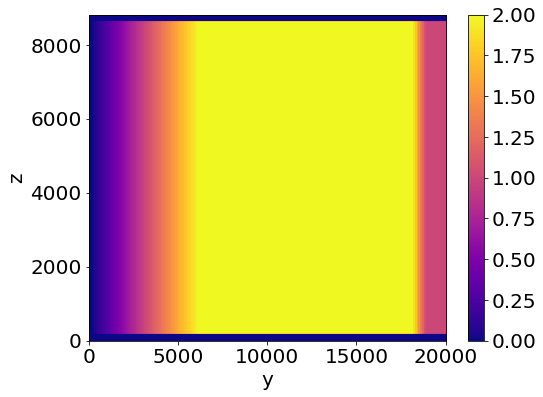

In [156]:
figure(figsize=((8,6)))

imshow(density2d
       #, extent=(y[0]*1.e6, y[-1]*1.e6, z[0]*1.e6, z[-1]*1.e6)
       , extent=(y[0]/dy_strict, y[-1]/dy_strict, z[0]/dz_strict, z[-1]/dz_strict)
       , interpolation='none'
       , origin='lower'
       #, vmin = , vmax = 
       , cmap=cm.plasma
       , aspect='auto'
)

xlabel(r"y")
ylabel(r"z")

colorbar()

show()

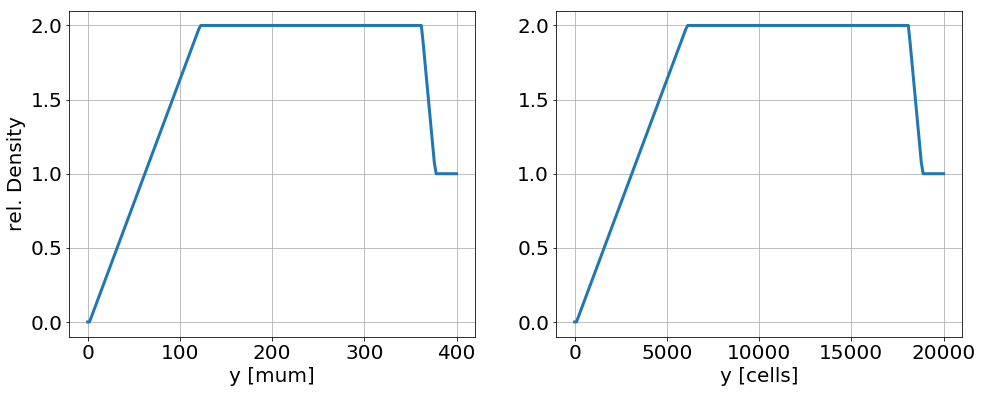

In [157]:
figure((figsize(16,6)))
subplot(1,2,1)

plot(y*1.e6, density2d[len(z)//2,:])

xlabel("y [mum]")
#xlim(0,500)
#xticks(arange(0,501,25))

ylabel("rel. Density")
grid()


subplot(1,2,2)
plot(y/dy_strict, density2d[len(z)//2,:])
xlabel("y [cells]")
grid()

show()

# Creating the example 

Branch: `topic-2019-10_TWEAC-for-Summit_0.4.3dev`

## `grid.param`

In [159]:
print("dt = {:.5e} s".format(dt_strict))
print("dx = {:.5e} m".format(dx_strict))
print("dy = {:.5e} m".format(dy_strict))
print("dz = {:.5e} m".format(dz_strict))

dt = 6.53658e-17 s
dx = 1.60000e-07 m
dy = 2.00000e-08 m
dz = 1.60000e-07 m


```c++
/** equals X
 *  unit: meter */
constexpr float_64 CELL_WIDTH_SI = 2.848e-09;
/** equals Y - the laser & moving window propagation direction
 *  unit: meter */
constexpr float_64 CELL_HEIGHT_SI = CELL_WIDTH_SI;
/** equals Z
 *  unit: meter */
constexpr float_64 CELL_DEPTH_SI = CELL_WIDTH_SI;

/** Duration of one timestep
 *  unit: seconds                       CFL criteria for Yee MW Solver
 *                                             2D: sqrt(2)
 *                                             3D: sqrt(3)   */
constexpr float_64 DELTA_T_SI = CELL_WIDTH_SI / ( 1.415 * SPEED_OF_LIGHT_SI );


/**
 *  ... ABSORBER ...
 */


/** When to start moving the co-moving window
 *
 *  ...
 */
constexpr float_64 movePoint = 1.012304;
```

### Set the correct move point for the moving window

See below at `particle.param` when the laser reaches its 'starting' position

## `components.param`
Nothing

## `fieldSolver.param`
Do we want anything else than `None` for the current interpolation?
- Yes, but later

![](20190204_Tafelbild.jpg)

## `laser.param`

laser parameters:
- a0 (focus) = 2
- FWHM intensity transversally = 20 µm
- intensity time FWHM = 15 fs
- $\lambda$ = 800 nm

We still need to figure out where the focus is in absolute units.
But to do so we need to decide how the acceleration takes place.

In [ ]:
a0_focus = 2

### Define bunch acceleration

In [ ]:
gamma_final = 500.

beta_final = np.sqrt(1. - 1./gamma_final**2)

print("beta final = %f"%beta_final)

# normalized accelerating field
ν_acc = sc.c / (100.*dx_strict) # Criterion: sample distance between first radiation wave front and particles 1000 times

t_final = gamma_final / ν_acc

# accelerating field strenght
E_acc = - ν_acc * sc.m_e * sc.c / sc.e
print("Accelerating field = %fGV/cm"%(E_acc*1.e-11))

print("energy gamma =", ν_acc*t_final)
Delta = sc.c/ν_acc
print("Strahlungsvorlauf = %.2fmum"%(Delta*1.e6))
print("Aufloesung des Strahlungsvorlaufs = %.2f"%(Delta/dx_strict))
print("exact Acceleration time = %.2fdt"%(t_final / dt_strict)) 

In [ ]:
# bunch acceleration time
steps_acc = 70800 # in this setup the electron field before the bunch amounts to 100 cells
print("USED Acceleration time = %.2fdt"%(steps_acc))
t_bunch_acc = steps_acc * dt_strict 



y_bunch_acc = sc.c * (np.sqrt(1 + ν_acc**2 * t_bunch_acc**2) - 1) / ν_acc
print("electron bunch acceleration length: {:.2f} µm".format(y_bunch_acc * 1e6))

cells_acc = np.int(y_bunch_acc / dx_strict)
print("acceleration on {} cells".format(cells_acc))

1. center of electron bunch initialization in absolute units
1. bunch acceleration length &#10004;
1. ~~free propagation length~~
1. distance laser and bunch
1. distance laser focus and foil surface
1. absolute position of foil surface

1. **5 $\sigma$ of bunch charge density inside box = 12.75µm**
2. just calculated above: **56.84µm**
3. we do not need that
4. given by experiment: **10µm** 
5. given by experiment: **250µm**
6. see plot below

## Simulation box overview

In [ ]:
def pre_plasma(x, x_s):
    """ 
        x = Distance from (initial) foil surface
        x_s = preplasma scale length
    """
    return np.exp(x / x_s) if ( x < 0 ) else 1.

In [ ]:
foil_preplasma_scale_length = 10.e-9 # [μm]
foil_preplasma_cutoff = 100.*foil_preplasma_scale_length # [μm]

plt.figure()

x = np.linspace(-1., 1., 200) * foil_preplasma_cutoff
y = np.array([ n_e_n_c * pre_plasma(x_i, foil_preplasma_scale_length) for x_i in x])

plt.plot(x * 1.e6, y)

plt.xlabel("x [μm]")
plt.ylabel("density [$n_c$]")
plt.yscale('log')

plt.show()

In [ ]:
fig,ax = plt.subplots(1,1)

ax.axvline(0, c="k", label="box origin")

e_bunch_start = 5 * σ_B * 1e6
ax.axvline(e_bunch_start, c="green", label="electron start", ls=":")

laser_start = e_bunch_start + d_L_to_B * 1e6
ax.axvline(laser_start, c="red", label="laser start", ls=":")

e_bunch_end = e_bunch_start + y_bunch_acc * 1e6
ax.axvline(e_bunch_end, c="green", label="electron end")

laser_end = e_bunch_end + d_L_to_B * 1e6
ax.axvline(laser_end, c="red", label="laser end")

preplasma_start = laser_end + 5 * σ_L * 1e6
ax.axvline(preplasma_start, c="blue", label="preplasma start", ls=":")

foil_start = preplasma_start + foil_preplasma_cutoff * 1e6
ax.axvline(foil_start, c="blue", label="foil start")

laser_focus = foil_start - z_foil * 1e6
ax.axvline(laser_focus, c="red", label="laser focus", ls="--")

plt.xticks(np.array([laser_focus,0,e_bunch_start,laser_start,e_bunch_end,laser_end, preplasma_start,foil_start]),
           rotation='vertical')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.axvspan(0,y_up,color="violet",alpha=0.2)

plt.xlabel("distance / µm")
plt.legend(loc="best",bbox_to_anchor=(1.1, 1.05))

We set:
- `static constexpr float_64 FOCUS_POS_SI = -74.473e-6;`
- `static constexpr float_64 PULSE_INIT = 5.0;`
- `static constexpr uint32_t initPlaneY = 0;`

So 5$\sigma$ of intensity before the pulse maximum which is (likely) enough to keep the intensity below the ionization threshold and not run the laser edge into the absorber at the simulation box front.

## `particle.param`

We need to set the acceleration pusher inactive at first, so that the laser pulse can travel from the initialization point at the boundary to its starting position through the electrons before we start accelerating them.
Otherwise they would Coulomb-explode because of their initial temperature. 

In [ ]:
plt.figure(figsize=(8,6))
nut = np.linspace(0., 100., 512)

plt.subplot(1,1,1)
plt.plot(nut, nut - np.sqrt(1. + nut**2) + 1.)

plt.xlabel("acceleration time [νt]")
plt.title("Distance between field front and electron [c/ν]")

plt.ylim(0,1)

plt.grid()

plt.tight_layout()

plt.show()

In [ ]:
# number of steps until the electron bunch becomes relativistic and moves as fast as the laser
beta_relativistic = 0.99
steps_till_relativistic = np.int(beta_relativistic / np.sqrt(1. - beta_relativistic**2) / ν_acc / dt_strict)

#steps_till_relativistic = Delta / (sc.c*dt_strict)
print("steps till relativistic = %i"%steps_till_relativistic)
print("velocity after steps_till_relativistic = %fc"%(ν_acc*steps_till_relativistic*dt_strict / np.sqrt(1. + (ν_acc*steps_till_relativistic*dt_strict)**2)))

# time until the acceleration pusher is set active
time_till_pusher_activation = ((5 * σ_L + laser_start / 1e6 ) / sc.c) - steps_till_relativistic * dt_strict
steps_till_pusher_activation = np.int(time_till_pusher_activation / dt_strict)
steps_till_window_moves = steps_till_pusher_activation + steps_till_relativistic
print("Steps till pusher activation: ",steps_till_pusher_activation)
print("Move point of moving Window= %f"%(steps_till_window_moves * dt_strict * sc.c / (box_cells_y * dx_strict) ))

In [ ]:
print(σ_L)
print(dt_strict)

We copied the `Particles.tpp` from the source code into the example, as well as the `particle.param`.
We set
- `constexpr uint32_t disable_pusher = 15050;`
- `Particles.tpp`:
```C++
Particles<...
>::update( uint32_t const currentStep )
{
    /* read `disable_pusher` from particle.param and activate pusher only after
     * the given number of time steps
     */
    if(currentStep < particles::disable_pusher)
        return;
 ```

Uses the manipulators:
- `OnceIonized`
- `TwiceIonized`
- `RandomPosition`
- ...

```C++
namespace startPosition
{
    struct RandomParameterFoil
    {   
        /** Count of particles per cell at initial state
         *
         *  unit: none
         */
        static constexpr uint32_t numParticlesPerCell = 10u; 
    };  
    using RandomFoil = RandomImpl< RandomParameterFoil >;

    struct RandomParameterBunch
    {   
        /** Count of particles per cell at initial state in the electron bunch
         *
         *  unit: none
         */
        static constexpr uint32_t numParticlesPerCell = 30u;
    };  
    using RandomBunch = RandomImpl< RandomParameterBunch >;
    
    // more start position manipulators
}

```

### Now we need to calculate the density distribution of the bunch to know what we will set as minimum weighting

In [ ]:
# bunch charge
Q_bunch = 200e-12 # Coulomb
N_e_bunch = Q_bunch / sc.e
print("Electrons in the bunch: {:.2e}".format(N_e_bunch))

In [ ]:
# cell volume
V_cell = dx_strict**3 # m³
print("cell volume: {:.2e}".format(V_cell))

# cell area
A_cell = dx_strict**2 # m³
print("cell area: {:.2e}".format(A_cell))

In [ ]:
def electron_dist(x, y, z, N_e_bunch=N_e_bunch, σ_x=σ_B_trans, σ_y=σ_B, σ_z=σ_B_trans):
    return (N_e_bunch / (2*np.pi)**(3/2) / (σ_x * σ_y * σ_z) 
            * np.exp(-(0.5*x**2/σ_x**2 + 0.5*y**2/σ_y**2 + 0.5*z**2/σ_z**2)))

def electron_dist_2D(x, y, N_e_bunch=N_e_bunch, σ_x=σ_B_trans, σ_y=σ_B):
    return (N_e_bunch / (2*np.pi) / (σ_x * σ_y) 
            * np.exp(-(0.5*x**2/σ_x**2 + 0.5*y**2/σ_y**2)))

electron peak density

In [ ]:
print("3D:", electron_dist(0,0,0))

print("2D:", electron_dist_2D(0,0))

In [ ]:
from scipy.integrate import dblquad, nquad

In [ ]:
ranges = np.array( [ [-5.*σ_B_trans, 5.*σ_B_trans], [-5.*σ_B, 5.*σ_B],  [-5.*σ_B, 5.*σ_B]] )
bunch_particles = nquad( electron_dist, ranges )
print("bunch particles =", bunch_particles[0] / N_e_bunch, "supposed to be 1" )
print( "bunch charge = %.4fpC"%(bunch_particles[0] * sc.e * 1.e12) )

In [ ]:
ranges = np.array( [ [-5.*σ_B_trans, 5.*σ_B_trans], [-5.*σ_B, 5.*σ_B]] )
slice_particle_density = nquad( electron_dist, ranges, args=(0.,) )
print("slice particles =", slice_particle_density[0] * dx_strict / N_e_bunch)
print( "slice charge = %.4fpC"%(slice_particle_density[0] * dx_strict * sc.e * 1.e12) )

electron density 5$\sigma$ away from the center

In [ ]:
print("longitudinal distance from center = %.2fµm"%(5.*σ_B*1.e6))
print("transverse distance from center = %.2fµm"%(5.*σ_B_trans*1.e6))

In [ ]:
print("3D:", electron_dist(5*σ_B_trans,0,0))
print("3D:", electron_dist(0,5*σ_B,0))

print("2D:", electron_dist_2D(5*σ_B_trans,0))
print("2D:", electron_dist_2D(0,5*σ_B))

number of real electrons per cell at 4.5$\sigma$ distance from the center

this will become our new value for the minimum weighting

In [ ]:
print("3D:", electron_dist(0.,5.*σ_B,0.) * V_cell)
print("3D:", electron_dist(0.,4.5*σ_B,0.) * V_cell)
print("2D:", electron_dist_2D(4.5*σ_B_trans,0) * A_cell)

```C++
constexpr float_X MIN_WEIGHTING = 2.5552e-05;
```

### Start position manipulator

```C++
    struct RandomParameterBunch
    {
        /** Count of particles per cell at initial state in the electron bunch
         *
         *  unit: none
         */
        static constexpr uint32_t numParticlesPerCell = 30u;
    };
    using RandomBunch = RandomImpl< RandomParameterBunch >;
```

### Temperature manipulator

To account for the emittance of the electron bunch we assign an initial temperature to it.

### Temperature of electron distribution in bunch <a class="tocSkip">

From [LECTURE  2:ELECTRON  EMISSION  AND  CATHODE  EMITTANCE by Dowell](http://uspas.fnal.gov/materials/10MIT/Lecture2_EmissionStatisticsCathodeEmittance_text.pdf)

Normalized emittance
$$
\epsilon_N = \beta\gamma \sigma_x \sigma_{x^\prime}
$$

The normalized rms thermal emittance is
$$
\epsilon_{N,thermal} = \sigma_x \frac{\sqrt{\langle v_x^2 \rangle}}{c}
$$
where for a Maxwell-Boltzmann Distribution
$$
\langle v_x^2 \rangle = \frac{k_B T}{m}
$$
and thus
$$
\epsilon_{N,thermal} = \sigma_x \sqrt{ \frac{k_B T}{m c^2} }
$$

In [ ]:
# calculate the electron distribution due to its temperature
eps_n = 0.1e-6 # [mm mrad] normalized emittance at full energy
kBT = (eps_n / σ_B_trans)**2 * sc.m_e * sc.c**2
print("electron temperature = %fkeV"%(kBT/sc.e*1.e-3))

```C++
/** Parameter for a temperature assignment to the bunch
 */
struct TemperatureParam
{
    /*Initial temperature
     *  unit: keV
     */
    static constexpr float_64 temperature = 4.534;
};
/* definition a temperature assignment manipulator */
using AddTemperature = unary::Temperature< TemperatureParam >;
```

## `pusher.param`

Filled in values calculated above.

```C++
struct particlePusherAccelerationParam
    {
        /** Define strength of constant and homogeneous accelerating
         *  electric field in SI per dimension.
         */

        /** unit: Volt / meter */
        static constexpr float_64 AMPLITUDEx_SI = 0.0;

        /**
         * The moving window propagation direction
         * unit: Volt / meter
         * (1e11 V/m = 1 GV/cm)
         */
        static constexpr float_64 AMPLITUDEy_SI = -17.940344e11;

        /** unit: Volt / meter */
        static constexpr float_64 AMPLITUDEz_SI = 0.0;

        /** Acceleration duration
         *  unit: second
         */
        static constexpr float_64 ACCELERATION_TIME_SI = (70800 + ::picongpu::particles::disable_pusher) * ::picongpu::SI::DELTA_T_SI;
    };
```

## `density.param`

Need two profiles, one for the foil and one for the bunch.
We already have the foil one from the previous branch.

### bunch profile

In [ ]:
print("longitudinal and transverse center position:")
print(30*"-")
print(e_bunch_start)
print(box_cells_x*dx_strict/2)
print("\n")
print("longitudinal and transverse sigma:")
print(30*"-")
print(σ_B)
print(σ_B_trans)

```C++

namespace SI
{
    /** Base density in particles per m^3 in the density profiles.
     *
     * This is often taken as reference maximum density in normalized profiles.
     * Individual particle species can define a `densityRatio` flag relative
     * to this value.
     *
     * unit: ELEMENTS/m^3
     *
     * We take n_e ("fully ionized") as reference density.
     * Our target material (see speciesDefinition) is a liquid crystal called
     * 8CB (4'-octyl-4-cyanobiphenyl).
     * 
     * Critical density nc = nc(lambda_laser=1.e-6) / lambda_laser[mu m]^2
     */
     constexpr float_64 nc = 1.114854e27 / 0.8 / 0.8;
    constexpr float_64 BASE_DENSITY_SI = 250.02 * nc; 

} // namespace SI


namespace densityProfiles
{

// ... Foil profile ...

PMACC_STRUCT(GaussianCloudParam,
    /** Profile Formula:
     *     exponent = |globalCellPos - center| / sigma
     *     density = e^[ gasFactor * exponent^gasPower ]
     */
    (PMACC_C_VALUE(float_X, gasFactor, -0.5))
    (PMACC_C_VALUE(float_X, gasPower, 2.0))

    /** height of vacuum area on top border
     *
     * this vacuum is important because of the laser initialization,
     * which is done in the first cell of the simulation
     * unit: cells
     *
     * in this case we would like no particles inside our absorbers
     */
    (PMACC_C_VALUE(uint32_t, vacuumCellsY, 132))

    /** The central position of the density distribution
     *  unit: meter
     */
    (PMACC_C_VECTOR_DIM(float_64, simDim, center_SI, 29.99416e-6, 12.7398e-6))

    /** the distance from gasCenter_SI until the density decreases to its 1/e-th part
      *  unit: meter */
    (PMACC_C_VECTOR_DIM(float_64, simDim, sigma_SI, 1.0617e-06, 2.5480e-06))
); /* struct GaussianCloudParam */

/* definition of cloud profile */
using GaussianCloud = GaussianCloudImpl< GaussianCloudParam >;

} //namespace density profiles
```

#### for mini example

In [ ]:
box_cells_x_mini = box_cells_x / 4
print("Box size = %.2f cells"%(box_cells_x_mini))
print("Electron bunch center x:", box_cells_x_mini//2 * dx_strict)

### foil profile

In [ ]:
print(foil_start)

```C++
struct FlatFoilWithRampFunctor
{
    /** This formula uses SI quantities only.
     *  The profile will be multiplied by BASE_DENSITY_SI.
     *
     * @param position_SI total offset including all slides [meter]
     * @param cellSize_SI cell sizes [meter]
     *
     * @return float_X density [normalized to 1.0]
     */
    HDINLINE float_X
    operator()(
        const floatD_64& position_SI,
        const float3_64& cellSize_SI
    )
    {
        // m -> mu
        const float_64 y( position_SI.y() * 1.e6 );

        // target begin & end (plateau)
        constexpr float_64 y0( 175.527 );
        constexpr float_64 y1( y0 + PARAM_THICKNESS );
        // exponential pre-expanded density
        constexpr float_64 L_pre( PARAM_PRE_SCALE );
        constexpr float_64 L_cutoff_pre( PARAM_PRE_CUTOFF * L_pre );

        // exponential post-expanded density
        constexpr float_64 L_post( PARAM_POST_SCALE );
        constexpr float_64 L_cutoff_post( PARAM_POST_CUTOFF * L_post );

        float_64 dens = 0.0;

        // upramp
        if( y < y0 && (y0 - y) < L_cutoff_pre )
            dens = math::exp( ( y - y0 ) / L_pre );
        // downramp
        if( y > y1 && (y - y1) < L_cutoff_post )
            dens = math::exp( ( y1 - y ) / L_post );
        // plateau
        if( y >= y0 && y <= y1 )
            dens = 1.0;

        // safety check: all parts of the function MUST be > 0
        dens *= float_64( dens >= 0.0 );
        return dens;
    }
};

// definition of free formula profile
using FlatFoilWithRamp = FreeFormulaImpl< FlatFoilWithRampFunctor >;
```

## `speciesAttributes.param`

Nothing to be done here

## `speciesConstants.param`

Nope

## `species.param`

```C++
using UsedParticleShape = particles::shapes::P4S;

using UsedParticleCurrentSolver = currentSolver::EmZ< UsedParticleShape >;

using UsedParticlePusher = particles::pusher::Boris;
```

## `speciesDefinition.param`

#### We need a new electron species for the bunch <a class="tocSkip">

In [ ]:
n_c = sc.epsilon_0 * sc.m_e / sc.e**2 * (2.*sc.pi*sc.c / 0.8e-6)**2
print(n_c)

n_e_bunch_max = electron_dist(0,0,0)/n_c
# maximum bunch density value in the center in n_c
print("Max. electron density in bunch: %.2e n_c"%(n_e_bunch_max))

In [ ]:
# density ratio for speciesInitialization for the bunch
density_ratio_bunch = n_e_bunch_max / n_e_n_c
print(density_ratio_bunch)

### TODO: possibly add index to bunch electrons for tracking

```C++
/*--------------------------- bunch electrons ---------------------------------*/
/* ratio relative to BASE_DENSITY (n_e) */
value_identifier( float_X, DensityRatioBunch, 6.337e-5 );

using ParticleFlagsBunch = bmpl::vector<
    particlePusher< particles::pusher::Acceleration >,
    shape< UsedParticleShape >,
    interpolation< UsedField2Particle >,
    current< UsedParticleCurrentSolver >,
    densityRatio< DensityRatioBunch >,
    massRatio< MassRatioElectrons >,
    chargeRatio< ChargeRatioElectrons >
>;

/* define species electrons */
using Bunch = Particles<
    PMACC_CSTRING( "b" ),
    ParticleFlagsBunch,
    DefaultParticleAttributes
>;

...
    
using VectorAllSpecies = MakeSeq_t<
    Bunch,
    Electrons,
    Hydrogen,
    Carbon,
    Nitrogen,
    Oxygen
    /* Probes // we leave out Probes for now */
>;
```

## `speciesInitialization.param`

```C++
using InitPipeline = mpl::vector<
    /* create the electron bunch at rest */
    CreateDensity<
        densityProfiles::GaussianCloud,
        startPosition::RandomBunch,
        Bunch
    >,
    /* add the initial temperature to the electron bunch */
    Manipulate<
        manipulators::AddTemperature,
        Bunch
    >,
    /* ... and the foil ... */
>
```

## `png.param`
```C++
constexpr float_64 scale_image = 1./64.;
```

## Intermezzo: transversal bunch temperature distribution

In [ ]:
energies = np.linspace(0,1e5,1000) # eV
# temperature calculated from emittance by Klaus
T = 4e3 # eV

f_e = 200 * 1e-12 / sc.e * np.exp(-energies / T)

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(f_e)
ax.set_yscale("log")
ax.set_ylim(1e5,1e10)

## `memory.param`
```C++
constexpr size_t reservedGpuMemorySize = 600 * 1024 * 1024;

/** bytes reserved for species exchange buffer
 *
 * This is the default configuration for species exchanges buffer sizes.
 * The default exchange buffer sizes can be changed per species by adding
 * the alias exchangeMemCfg with similar members like in DefaultExchangeMemCfg
 * to its flag list.
 */
struct DefaultExchangeMemCfg
{   
    // memory used for a direction
    static constexpr uint32_t BYTES_EXCHANGE_X = 2 * 3 * 1024 * 1024; // 6 MiB, orig: 3 MiB
    static constexpr uint32_t BYTES_EXCHANGE_Y = 5 * 16 * 1024 * 1024; // 80 MiB, orig: 6 MiB
    static constexpr uint32_t BYTES_EXCHANGE_Z = 2 * 3 * 1024 * 1024; // 6 MiB, orig: 3 MiB
    static constexpr uint32_t BYTES_EDGES = 128 * 1024; // 128 kiB
    static constexpr uint32_t BYTES_CORNER = 32 * 1024; // 32 kiB
};

```

# Config files

## Names

- 128_V100_1000nm_pre_plasma.cfg <font color="green" size=6>&#10004;</font>
- 128_V100_100nm_pre_plasma.cfg <font color="green" size=6>&#10004;</font>
- 128_V100_10nm_pre_plasma.cfg <font color="green" size=6>&#10004;</font>

Still need a configuration for the smaller `k80` GPUs

## What we need to address

- checkpoint times:
    - restart and change from acceleration pusher to normal pusher for bunch <font color="green" size=6>&#10004;</font>
    - laser pulse maximum on foil (critical density) surface (or slightly before) <font color="green" size=6>&#10004;</font>
    - start of bunch-pulse interaction for inverse compton scattering <font color="green" size=6>&#10004;</font> (basically same as laser max on foil)
    - electrons entering the foil <font color="green" size=6>&#10004;</font>
    - rough period of checkpoints for restarting in case of crash <font color="green" size=6>&#10004;</font>
    - electron peak leaves the foil <font color="green" size=6>&#10004;</font>
    
- **all foil species** diagnostics:
    - start them only shortly before the foil slides into the box 
    - stop them / decrease output period drastically after all of the foil has left the box (only track protons or other particles that might fly along with the bunch electrons)
    
- `energyHistogram`
    - add for bunch 
    - change all output times
    - define the energy ranges
    
- `phaseSpace`
    - add for bunch
    - output times
    - momentum ranges
    
- `countParticles`
    - all species: lets us see when some of them vanish

- `sumEnergy`
    - all species
    
- `chargeConservation`
    - output times
    
- `hdf5` or `adios`?
    - it's 2D and the last time I wrote 84GB in 3s $\Longrightarrow$ `hdf5`
    - separate bunch output and foil output and fields and choose reasonable output times

- `png`
    - add for foil electrons
    - ... bunch
    - protons
    
- emittance plugin
    - find out out to configure by executing `picongpu -h` or checking the `tpp`
    - set it up for the bunch species only
    

### Checkpoint times

In [ ]:
print(steps_till_pusher_activation)

In [ ]:
print("steps till bunch relativistic", steps_till_pusher_activation+steps_till_relativistic)

In [ ]:
# time in steps until the checkpoint and pusher change
steps_change_pusher = steps_acc + steps_till_pusher_activation
print(steps_change_pusher)

In [ ]:
# number of steps until the preplasma of the foil slides into the box
# moving WIndow right edge: L_box + ( n_steps - n_steps_till_window_moves) * c * dt != preplasma_start
steps_foil_slides_into_box = ( int( ( preplasma_start*1e-6 - box_cells_y * dx_strict ) / sc.c / dt_strict ) 
                              + steps_till_window_moves )
print(steps_foil_slides_into_box)

In [ ]:
# the edge of the electron bunch starts interacting with the foil
steps_bunch_enters_foil = np.int(((foil_start - e_bunch_end) * 1e-6 - 5 * σ_B) / sc.c / dt_strict) + steps_change_pusher
print(steps_bunch_enters_foil)

In [ ]:
steps_laser_max_on_foil = np.int((foil_start-laser_end)*1e-6 / sc.c / dt_strict) + steps_change_pusher
print(steps_laser_max_on_foil)

In [ ]:
print("5 sigma electron bunch: ",5 * σ_B * 1e6,"µm")

In [ ]:
steps_bunch_max_leaves_foil = np.int(steps_bunch_enters_foil + ((5 * σ_B + d_Kapton)/sc.c / dt_strict))
print(steps_bunch_max_leaves_foil)

In [ ]:
steps_bunch_rear_leaves_foil = np.int(steps_bunch_max_leaves_foil + (5 * σ_B) / sc.c / dt_strict)
print(steps_bunch_rear_leaves_foil)

In [ ]:
200000 / 60 / 60 / 24

### Histograms

In [ ]:
# foil electron average gamma
γ_e_foil = np.sqrt(1 + 0.5*a0_focus**2)
# foil electron average kinetic energy
kBT_e_foil = (γ_e_foil - 1) * sc.m_e * sc.c**2 / sc.e
print("electron average kinetic energy at foil front: ",kBT_e_foil," keV")

In [ ]:
E_e_foil = np.linspace(0,50e6,1000)
dN_dE_e_foil = 1e11 * np.exp(-E_e_foil/kBT_e_foil)

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(E_e_foil / 1e6,dN_dE_e_foil)
ax.set_yscale("log")
plt.xlabel("kinetic energy / MeV")
plt.ylabel()
plt.title("foil \'prompt\' electron energy distribution")

### phase space


### HDF5

```Shell
# time until the laser has traveled to its starting position and we enable the bunch acceleration pusher
# @see particle.param
TBG_disable_pusher="39155"
# time when the bunch electrons should be relativistic
TBG_bunch_relativistic="40155"
# time at which the foil (preplasma) slides into
TBG_foil_enters_box="103738"
# time at which we will write a checkpoint and restart for change from the acceleration pusher
# to the normal pusher for the bunch electrons
TBG_change_pusher="109955"
# time at which the bunch edge (5 sigma) enters the foil
TBG_bunch_enters_foil="118427"
# time at which the laser maximum hits the cold, unexpanded foil surface
TBG_laser_max_on_foil="121833"
# time at which the bunch maximum leaves the foil
TBG_bunch_max_leaves_foil="165345"
# time at which the bunch rear edge leaves the foil
TBG_bunch_rear_leaves_foil="181183"
```

```Shell
TBG_hdf5_fields_period=" 
0:!TBG_bunch_enters_foil:10000,
!TBG_change_pusher:!TBG_change_pusher,
!TBG_bunch_enters_foil:!TBG_bunch_enters_foil,
!TBG_laser_max_on_foil:!TBG_laser_max_on_foil,
!TBG_bunch_enters_foil:!TBG_bunch_max_leaves_foil:2500,
!TBG_bunch_max_leaves_foil:!TBG_bunch_max_leaves_foil,
!TBG_bunch_max_leaves_foil:!TBG_bunch_rear_leaves_foil:5000,
!TBG_bunch_rear_leaves_foil:!TBG_bunch_rear_leaves_foil,
!TBG_bunch_rear_leaves_foil::10000
"
TBG_hdf5_foil_particles_period="
!TBG_foil_enters_box:!TBG_bunch_enters_foil:2500,
!TBG_bunch_enters_foil:!TBG_bunch_max_leaves_foil:2500,
!TBG_bunch_max_leaves_foil:!TBG_bunch_rear_leaves_foil:5000,
!TBG_bunch_rear_leaves_foil::10000 
"

TBG_bunch_particles=
0:0,
!TBG_disable_pusher:!TBG_bunch_relativistic:250,
!TBG_bunch_relativistic:!TBG_change_pusher:10000,
!TBG_change_pusher:!TBG_bunch_enters_foil:5000,
!TBG_bunch_enters_foil:!TBG_bunch_max_leaves_foil:500,
!TBG_bunch_max_leaves_foil:!TBG_bunch_rear_leaves_foil:2500,
!TBG_bunch_rear_leaves_foil::5000
```